<a href="https://colab.research.google.com/github/HuiningLiu02/TIF360-Advanced-machine-learning-with-neural-networks/blob/main/vae_mnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Generating Digit Images with a Variational Autoencoder


<div style="background-color: #f0f8ff; border: 2px solid #4682b4; padding: 10px;">
<a href="https://colab.research.google.com/github/DeepTrackAI/DeepLearningCrashCourse/blob/main/Ch04_AE/ec04_A_vae_mnist/vae_mnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
<strong>If using Colab/Kaggle:</strong> You need to uncomment the code in the cell below this one.
</div>

In [1]:
!pip install deeplay deeptrack  # Uncomment if using Colab/Kaggle.

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 2.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 177.3/177.3 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 195.6/195.6 kB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 47.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 41.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 23.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.3 MB/s eta 0:00:00
 

This notebook provides you with a complete code example that
trains a variational autoencoder on the MNIST digits and uses it to generated
new digit images and cluster the digits in the latent space.

<div style="background-color: #f0f8ff; border: 2px solid #4682b4; padding: 10px;">
<strong>Note:</strong> This notebook contains the Code Example 4-A from the book  

**Deep Learning Crash Course**  
Benjamin Midtvedt, Jesús Pineda, Henrik Klein Moberg, Harshith Bachimanchi, Joana B. Pereira, Carlo Manzo, Giovanni Volpe  
No Starch Press, San Francisco (CA), 2025  
ISBN-13: 9781718503922  

[https://nostarch.com/deep-learning-crash-course](https://nostarch.com/deep-learning-crash-course)

You can find the other notebooks on the [Deep Learning Crash Course GitHub page](https://github.com/DeepTrackAI/DeepLearningCrashCourse).
</div>

## Loading the MNIST Dataset

The MNIST dataset consists of grayscale images of hand-written digits from 0 to 9. Each image is 28 pixels by 28 pixels. There're 60,000 training images and 10,000 test images.

Import the MNIST dataset ...

In [ ]:
import os
import deeptrack as dt

if not os.path.exists("MNIST_dataset"):
    os.system("git clone https://github.com/DeepTrackAI/MNIST_dataset")

data_dir = os.path.join("MNIST_dataset", "mnist")
train_files = dt.sources.ImageFolder(root=os.path.join(data_dir, "train"))
test_files = dt.sources.ImageFolder(root=os.path.join(data_dir, "test"))
files = dt.sources.Join(train_files, test_files)

print(f"Number of train images: {len(train_files)}")
print(f"Number of test images: {len(test_files)}")

Cloning into 'MNIST_dataset'...
Updating files: 100% (70003/70003), done.


Number of train images: 60000
Number of test images: 10000


... create an image pipeline.

In [ ]:
import torch

image_pip = (dt.LoadImage(files.path) >> dt.NormalizeMinMax()
             >> dt.MoveAxis(2, 0) >> dt.pytorch.ToTensor(dtype=torch.float))

In [2]:
!pip install medmnist

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.2/87.2 kB 6.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for fire: filename=fire-0.7.0-py3-none-any.whl size=114249 sha256=34b6f74ad18be3647685669fdfd45c14d2195397646647612f235e674adfa42f
  Stored in directory: /root/.cache/pip/wheels/46/54/24/1624fd5b8674eb1188623f7e8e17cdf7c0f6c24b609dfb8a89
Successfully built fire


In [54]:
import medmnist
from medmnist import INFO, Evaluator
import torchvision.transforms as transforms

data_flag = 'bloodmnist'
# data_flag = 'breastmnist'
download = True
info = INFO[data_flag]
DataClass = getattr(medmnist, info['python_class'])


# preprocessing
data_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
    transforms.Lambda(lambda x: (x - x.min()) / (x.max() - x.min()))
    #transforms.Normalize(mean=[.5], std=[.5])
])

# load the data
train_dataset = DataClass(split='train', transform=data_transform, download=download)
test_dataset = DataClass(split='test', transform=data_transform, download=download)

#train_dataset = PathMNIST(split="train")

In [53]:
print(type(train_dataset))

<class 'medmnist.dataset.BloodMNIST'>


In [55]:
# 取一个样本看 shape
img, label = train_dataset[0]
print(f"图像 shape: {img}")  # 应该是 torch.Size([1, H, W])
print(f"标签: {label}")

图像 shape: tensor([[[0.9189, 0.9514, 0.9189, 0.7892, 0.6486, 0.5892, 0.6162, 0.6541,
          0.6703, 0.6108, 0.5892, 0.6162, 0.6811, 0.8216, 0.9243, 0.9135,
          0.8486, 0.8108, 0.8054, 0.8000, 0.8162, 0.9081, 0.9622, 0.9297,
          0.9568, 0.9676, 0.9297, 0.9514],
         [0.9514, 0.9514, 0.8811, 0.7297, 0.6054, 0.6000, 0.6865, 0.7676,
          0.7405, 0.6649, 0.6216, 0.6054, 0.6486, 0.7892, 0.9081, 0.9189,
          0.9459, 0.9135, 0.9027, 0.8973, 0.8865, 0.9189, 0.9351, 0.8919,
          0.9189, 0.9459, 0.9459, 0.9838],
         [0.9568, 0.9405, 0.8486, 0.6919, 0.5838, 0.6216, 0.7622, 0.8703,
          0.8432, 0.7459, 0.6595, 0.6000, 0.6054, 0.7405, 0.8919, 0.9297,
          0.9568, 0.9405, 0.9405, 0.9514, 0.9568, 0.9514, 0.9514, 0.9459,
          0.9514, 0.9568, 0.9297, 0.9838],
         [0.9297, 0.9189, 0.8432, 0.6973, 0.6000, 0.6432, 0.7784, 0.8919,
          0.9135, 0.8054, 0.6919, 0.6000, 0.5784, 0.7135, 0.8865, 0.9405,
          0.9243, 0.9135, 0.9135, 0.9405, 0.940

image shape: torch.Size([1, 28, 28])


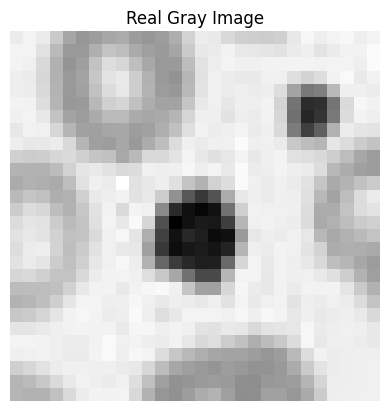

In [46]:
import matplotlib.pyplot as plt

img, _ = train_dataset[0]

print(f"image shape: {img.shape}")  # 应该是 [1, H, W]
plt.imshow(img.squeeze(), cmap='gray')  # 强制使用灰度色图
plt.title("Real Gray Image")
plt.axis('off')
plt.show()

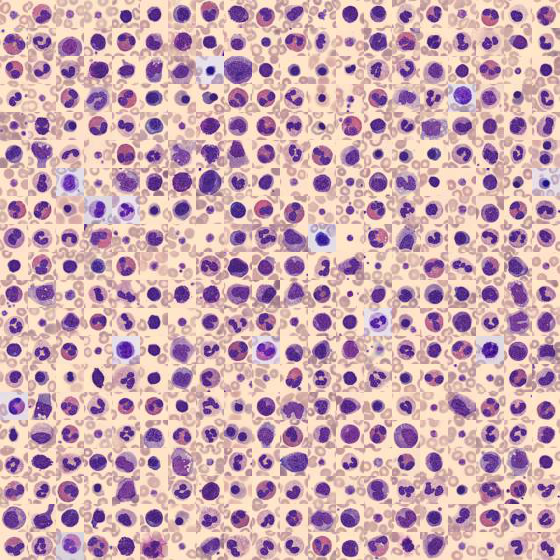

In [47]:
train_dataset.montage(length=20)

In [56]:
from torch.utils.data import Dataset
class ImageAsLabelDataset(Dataset):
    def __init__(self, medmnist_dataset):
        self.data = medmnist_dataset

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image, _ = self.data[idx]
        return image, image  # ✅ label 就是 image 本身

In [58]:
vae_train_dataset = ImageAsLabelDataset(train_dataset)
train_loader = torch.utils.data.DataLoader(vae_train_dataset, batch_size=64, shuffle=True)

In [60]:
img, label = vae_train_dataset[0]
print(f"图像 shape: {img}")  # 应该是 torch.Size([1, H, W])
print(f"标签: {label}")

图像 shape: tensor([[[0.9189, 0.9514, 0.9189, 0.7892, 0.6486, 0.5892, 0.6162, 0.6541,
          0.6703, 0.6108, 0.5892, 0.6162, 0.6811, 0.8216, 0.9243, 0.9135,
          0.8486, 0.8108, 0.8054, 0.8000, 0.8162, 0.9081, 0.9622, 0.9297,
          0.9568, 0.9676, 0.9297, 0.9514],
         [0.9514, 0.9514, 0.8811, 0.7297, 0.6054, 0.6000, 0.6865, 0.7676,
          0.7405, 0.6649, 0.6216, 0.6054, 0.6486, 0.7892, 0.9081, 0.9189,
          0.9459, 0.9135, 0.9027, 0.8973, 0.8865, 0.9189, 0.9351, 0.8919,
          0.9189, 0.9459, 0.9459, 0.9838],
         [0.9568, 0.9405, 0.8486, 0.6919, 0.5838, 0.6216, 0.7622, 0.8703,
          0.8432, 0.7459, 0.6595, 0.6000, 0.6054, 0.7405, 0.8919, 0.9297,
          0.9568, 0.9405, 0.9405, 0.9514, 0.9568, 0.9514, 0.9514, 0.9459,
          0.9514, 0.9568, 0.9297, 0.9838],
         [0.9297, 0.9189, 0.8432, 0.6973, 0.6000, 0.6432, 0.7784, 0.8919,
          0.9135, 0.8054, 0.6919, 0.6000, 0.5784, 0.7135, 0.8865, 0.9405,
          0.9243, 0.9135, 0.9135, 0.9405, 0.940

In [61]:
batch = next(iter(train_loader))
print(type(batch))     # tuple
print(len(batch))      # 2
print(batch[0].shape)  # torch.Size([64, 1, H, W])
print(batch[1].shape)  # torch.Size([64, 1, H, W])

<class 'list'>
2
torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])


In [62]:
img = next(iter(train_loader))[1]
print(img.min(), img.max())

tensor(0.) tensor(1.)


## Training the Variational Autoencoder

Define the variational autoencoder ...

In [40]:
import deeplay as dl
import torch

vae = dl.VariationalAutoEncoder(
    latent_dim=2, channels=[32, 64],
    reconstruction_loss=torch.nn.BCELoss(reduction="sum"), beta=1,
).create()

print(vae)

VariationalAutoEncoder(
  (encoder): ConvolutionalEncoder2d(
    (blocks): LayerList(
      (0): Conv2dBlock(
        (layer): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (activation): ReLU()
      )
      (1): Conv2dBlock(
        (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (layer): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (activation): ReLU()
      )
      (2): Conv2dBlock(
        (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (layer): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (activation): Identity()
      )
    )
    (postprocess): Flatten(start_dim=1, end_dim=-1)
  )
  (fc_mu): Linear(in_features=3136, out_features=2, bias=True)
  (fc_var): Linear(in_features=3136, out_features=2, bias=True)
  (fc_dec): Linear(in_features=2, out_features=3136, bias=True)
  (decoder): ConvolutionalDecoder2d(
    (bl

... define the train dataset and data loader ...

... and train the variational autoencoder ...

In [63]:
vae_trainer = dl.Trainer(max_epochs=10, accelerator="auto")
vae_trainer.fit(vae, train_loader)

/usr/local/lib/python3.11/dist-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
INFO: 
  | Name                | Type                   | Params | Mode 
-----------------------------------------------------------------------
0 | encoder             | ConvolutionalEncoder2d | 55.7 K | train
1 | fc_mu               | Linear                 | 6.3 K  | train
2 | fc_var              | Linear                 | 6.3 K  | train
3 | fc_dec              | Linear                 | 9.4 K  | train
4 | decoder             | ConvolutionalDecoder2d | 76.3 K | train
5 | reconstruction_loss | BCELoss                | 0      | train
6 | train_metrics       | MetricCollection       | 0      | train
7 | val_metrics         | MetricCollection       | 0      | train
8 | test_metrics        | MetricCollection       | 0      | train
9 | optimizer           | Adam                   | 0      | train
-----------------

Training: |          | 0/? [00:00<?, ?it/s]

## Generating Digit Images with the Decoder

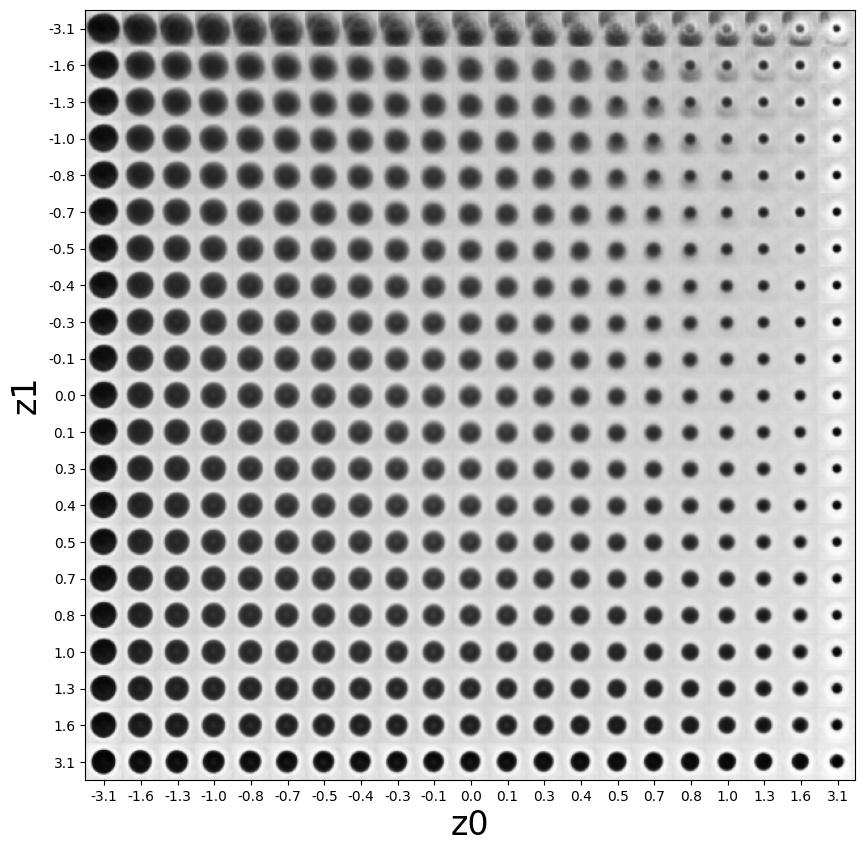

In [64]:
import numpy as np
import matplotlib.pyplot as plt
from torch.distributions.normal import Normal

img_num, img_size = 21, 28
z0_grid = z1_grid = Normal(0, 1).icdf(torch.linspace(0.001, 0.999, img_num))

image = np.zeros((img_num * img_size, img_num * img_size))
for i0, z0 in enumerate(z0_grid):
    for i1, z1 in enumerate(z1_grid):
      z = torch.stack((z0, z1)).unsqueeze(0)
      generated_image = vae.decode(z).clone().detach()
      image[i1 * img_size : (i1 + 1) * img_size,
            i0 * img_size : (i0 + 1) * img_size] = \
          generated_image.numpy().squeeze()

plt.figure(figsize=(10, 10))
plt.imshow(image, cmap="gray")
plt.xlabel("z0", fontsize=24)
plt.xticks(np.arange(0.5 * img_size, (0.5 + img_num) * img_size, img_size),
           np.round(z0_grid.numpy(), 1))
plt.ylabel("z1", fontsize=24)
plt.yticks(np.arange(0.5 * img_size, (0.5 + img_num) * img_size, img_size),
           np.round(z1_grid.numpy(), 1))
plt.show()

## Clustering the Digit Images in the Latent Space with the Encoder

Define a pipeline combining the test images and their digit values (labels) ...

In [65]:
test_dataset = DataClass(split='test', transform=data_transform, download=download)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=True)

... encode the test images in the latent space ...

In [66]:
mu_list, test_labels = [], []
for image, label in test_loader:
    mu, _ = vae.encode(image)
    mu_list.append(mu)
    test_labels.append(label)
mu_array = torch.cat(mu_list, dim=0).detach().numpy()
test_labels = torch.cat(test_labels, dim=0).numpy()

... plot the latent space.

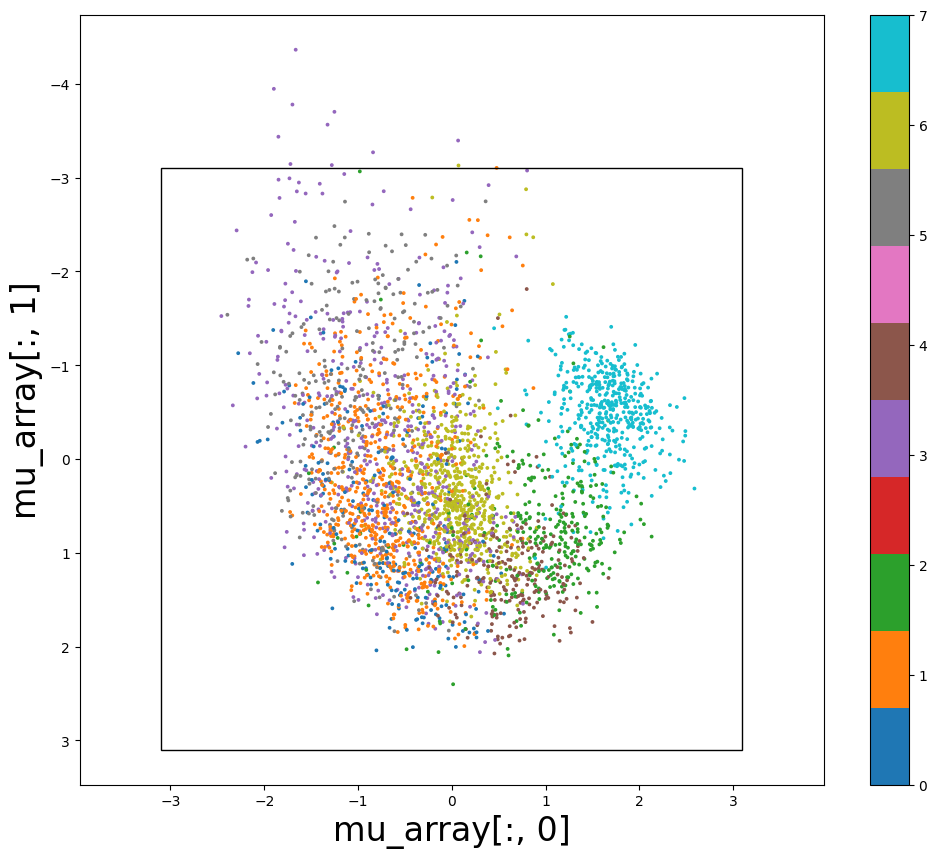

In [67]:
from matplotlib.patches import Rectangle

plt.figure(figsize=(12, 10))
plt.scatter(mu_array[:, 0], mu_array[:, 1], s=3, c=test_labels, cmap="tab10")
plt.gca().add_patch(Rectangle((-3.1, -3.1), 6.2, 6.2, fc="none", ec="k", lw=1))
plt.xlabel("mu_array[:, 0]", fontsize=24)
plt.ylabel("mu_array[:, 1]", fontsize=24)
plt.gca().invert_yaxis()
plt.axis("equal")
plt.colorbar()
plt.show()